In [60]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas_datareader.data as reader
import math
import matplotlib.pyplot as plt

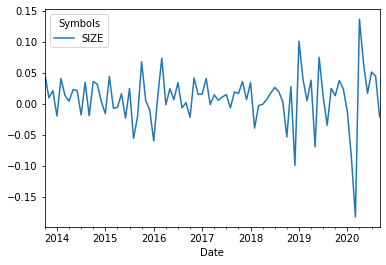

In [63]:
end = dt.date(2020,10,1)
start = dt.date(end.year - 7 , end.month, end.day)
portfolio = 'SIZE' #SMART BETA FUND, Globalex ETF FACTOR FUND (MIN_VOLITILITY,MOM,VALUE)
fund = [portfolio]
fund_returns = reader.get_data_yahoo(fund,start,end)['Adj Close'].pct_change()
fund_returns_mt = fund_returns.resample('M').agg(lambda x:(x+1).prod()-1)
fund_returns_mt = fund_returns_mt[:-1]
fund_returns_mt.plot()


In [71]:
factors = reader.DataReader('F-F_Research_Data_Factors','famafrench',start,end)
factors = factors[0]

In [77]:
fund_returns_mt.index = factors.index
full_dataset = pd.merge(fund_returns_mt,factors,on='Date')
full_dataset[['Mkt-RF','SMB','HML','RF']]= full_dataset[['Mkt-RF','SMB','HML','RF']]/100 #coverting from percent to raw value 
full_dataset[portfolio +' - RF']=full_dataset[portfolio] - full_dataset['RF'] #Excess Return = Portfolio - RF
full_dataset=full_dataset.rename(columns = {'SIZE':portfolio + ' Raw Returns'})
full_dataset
train = (len(full_dataset)*.8)
train = math.floor(train)
train_data = full_dataset.iloc[0:train, :]
test_data = full_dataset.iloc[train:, :]
train_data.head()

,SIZE Raw Returns,Mkt-RF,SMB,HML,RF,SIZE - RF
Date,,,,,,
2013-10,0.048794,0.0418,-0.0153,0.0120,0.0,0.048794
2013-11,0.009804,0.0313,0.0118,0.0031,0.0,0.009804
2013-12,0.021208,0.0281,-0.0058,-0.0005,0.0,0.021208
2014-01,-0.019472,-0.0332,0.0087,-0.0202,0.0,-0.019472
2014-02,0.040780,0.0465,0.0031,-0.0037,0.0,0.040780


       SIZE Raw Returns     Mkt-RF
count         84.000000  84.000000
mean           0.009193   0.010093
std            0.042253   0.041287
min           -0.182483  -0.133800
25%           -0.006548  -0.001300
50%            0.013330   0.012750
75%            0.032252   0.031450
max            0.136593   0.136500
AxesSubplot(0.125,0.125;0.775x0.755)


C:\Users\Byeke\Anaconda3\lib\site-packages\statsmodels\stats\_lilliefors.py:272: FutureWarning: The default pvalmethod will change from "approx" to "table" after 0.11. The "table" method uses values from a very large simulation and is more accurate.  Explicitly set this parameter to "approx" or "table" to silence this warning
  warnings.warn(msg, FutureWarning)


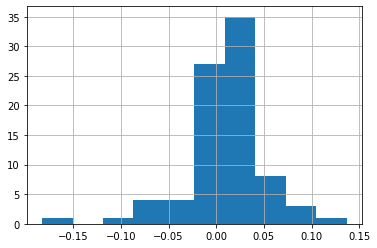

In [90]:
print(full_dataset[[portfolio + ' Raw Returns','Mkt-RF']].describe())
print(full_dataset['SIZE Raw Returns'].hist())
KS_Test = sm.stats.diagnostic.kstest_normal(full_dataset['SIZE Raw Returns'],dist= 'norm')

In [99]:
x_train = train_data[['Mkt-RF','SMB','HML']]
y_train = train_data['SIZE - RF']
x_test = test_data[['Mkt-RF','SMB','HML']]
y_test = test_data['SIZE - RF']
x = sm.add_constant(x_train) #add's a non-zero alpha into regression
x_t = sm.add_constant(x_test) #add's a non-zero alpha into regression

                            OLS Regression Results                            
Dep. Variable:              SIZE - RF   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     234.7
Date:                Wed, 28 Oct 2020   Prob (F-statistic):           3.93e-34
Time:                        16:22:03   Log-Likelihood:                 221.31
No. Observations:                  67   AIC:                            -434.6
Df Residuals:                      63   BIC:                            -425.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.537      0.5

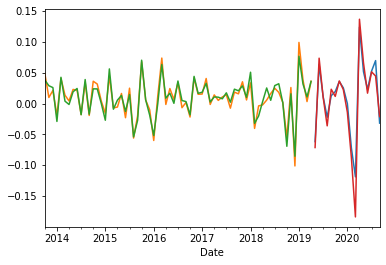

In [100]:
#Modeling & Plotting Results
model = sm.OLS(y_train,x)
results = model.fit()
print(results.summary())
results.params 
results.rsquared
y_hat_train = results.predict(x) #in sample prediction
y_hat_test = results.predict(x_t) #out of sample prediction
y_hat_test.plot() #blue, out of sample prediciton
y_train.plot() #yellow, in-sample actual excess
y_hat_train.plot() #green, in-sample prediction 
y_test.plot() # red, out of sample actual excess
#ax = plt.subplot()
#ax.plot(y_hat_train, label = "In-Sample Prediction")
#ax.plot(y_hat_test, label = "Out-of-Sample Prediction")
#ax.plot(y_train, label = 'In-Sample Actual')
#ax.plot(y_test, label = 'Out-of-Sample Actual')
#ax.legend()

In [57]:
#table = sm.stats.anova_lm(results, typ = 2)

The in-sample MSE is 8.942827933772772e-36


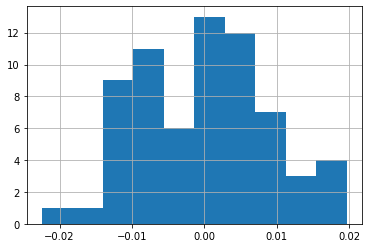

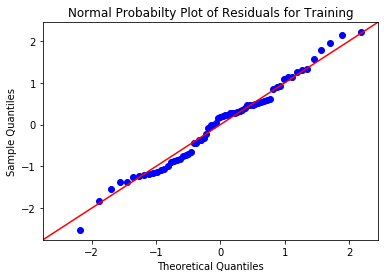

In [101]:
# Residuals/Epsilon Analysis
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test
train_MSE = (train_residuals.mean())**2
print("The in-sample MSE is " +str(train_MSE))
train_residuals.hist() #in-sample residual/idiosycratic_risk hist
pplot = sm.ProbPlot(train_residuals,fit = True) #normal prob plot in-sample
fig = pplot.qqplot(line = '45')
plt.title("Normal Probabilty Plot of Residuals for Training")
plt.show()